# Predicting heart disease using Machine Learning.

## Introduction

Cardiovascular diseases are a leading cause of morbidity and mortality worldwide. Timely identification and prediction of heart diseases can significantly improve patient outcomes. In this notebook, we will explore the development of a machine learning model to predict the likelihood of a patient having heart disease based on a set of health-related features.

## Problem definition

Predicting the likelihood of patients having a heart disease based on a set of clinical features.

## Required libraries

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **NumPy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **Seaborn**: Advanced statistical plotting library.

## Data

we will be using the [Cardiovascular disease Kaggle dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data)

## Goal

The primary objective is to create a robust machine learning model that can analyze the provided dataset and make accurate predictions about the presence or absence of heart disease. We will go through the following steps:

1. EDA: Understand the structure and characteristics of the dataset.
2. Data Preprocessing: Clean and prepare the data for training.
3. Feature Engineering: Identify key features that influence heart disease prediction.
4. Model Selection: Choose a suitable machine learning algorithm for classification.
5. Model Training: Train the selected model on the dataset.
6. Model Evaluation: Assess the performance of the model using appropriate metrics.
7. Hyperparameter Tuning: Optimize the model parameters for better accuracy.
8. Prediction: Make predictions on new data using the trained model.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv("./data/heart_disease.csv")

## 1- Exploratory Data Analysis

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


### 1. Univariate analysis

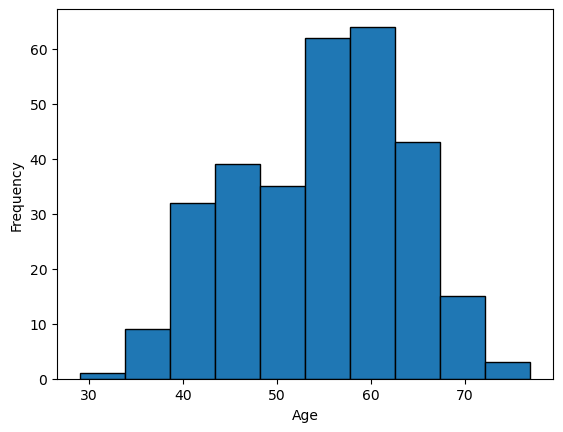

In [6]:
plt.hist(df['age'], edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency');

the distribution of the age variable looks like a quasi-normal distribution.
let's verify it using the Shapiro-Wilk test for a threshhold of 5% 

In [27]:
from scipy.stats import shapiro

shapiro(df.age)

ShapiroResult(statistic=0.9856191277503967, pvalue=0.004022137261927128)

we got a pvalue equal to 0.4% which is signficantly smaller than 5%
age is not normally distributed 
let's check quasi-normality

In [30]:
df.age.skew(), df.age.kurt()

(-0.2274479934315017, -0.5090180686747039)

- the kurtosis and skewness of the age variable are both between -3 and 3. we can conclude that it's quasi-normal.

- The assumption of normality is often associated with statistical tests and models that rely on the normal distribution, such as t-tests or linear regression. However, many machine learning algorithms, especially those based on decision trees, ensemble methods, or neural networks, are less sensitive to the distribution of the input features. In such cases, the normal distribution assumption is not strictly necessary.
for that reason we can carry on our EDA without caring much about the normality of our data.

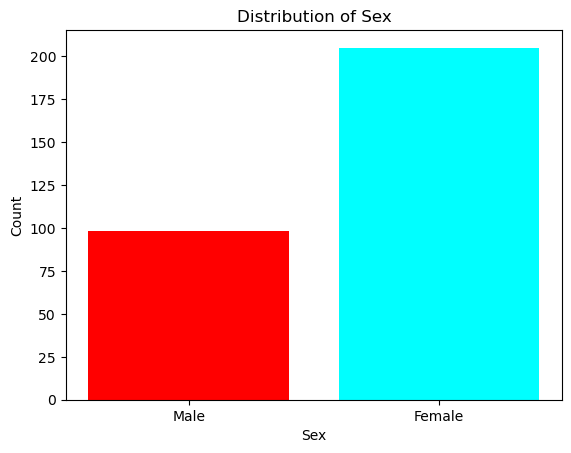

In [23]:
counts = df.sex.value_counts()
plt.bar(counts.index, counts.values, color=['cyan', 'red'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.xticks([0, 1], ['Male', 'Female']);

**Heads-up** : Clearly the dataset in our hands is not balanced in terms of sex. This can cause the models to be biased towards the majority class (Female in this case), and perform poorly on the minority class.
This is a point to be taken into consideration when we are evaluating our models.